# Environment Setup

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark as snp
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
import snowflake.snowpark.window as W

import pandas as pd
import json
import seaborn as sns

from snowflake.ml.modeling.lightgbm import LGBMClassifier
from snowflake.ml.modeling.metrics import *

## Create Snowpark Session

In [2]:
# Make a Snowpark Connection
# Edit the connection.json before creating the session object below
# Create Snowflake Session object

connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
# require specific numpy version for LGBM
session.custom_package_usage_config = {"enabled": True}
session.add_packages(["numpy==1.26.3"])

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Parameter custom_package_usage_config is experimental since 1.6.0. Do not use it in production. 



Connection Established with the following parameters:
User                        : JOHN
Role                        : "ACCOUNTADMIN"
Database                    : "SCORED_MODEL"
Schema                      : "SCORED_MODEL"
Warehouse                   : "QUERY_WH"
Snowflake version           : 8.3.1
Snowpark for Python version : 1.11.1


## Feature Engineering

This notebook is based on the worksheet found here (https://www.kaggle.com/code/ambrosm/amex-lightgbm-quickstart), with some modifications. The dataset has multiple values per customer ID, so we will undertake some feature engineering to find the mean, standard deviation, min, max and last values of each customer ID, so we have features and customer ID as a unique key.

In [3]:
#Create Snowpark df from shared data
training_df = session.table('"CC_DEFAULT_TRAINING_DATA"."DATA_SHARING_DEMO"."CC_DEFAULT_TRAINING_DATA"')

In [4]:
# Check number of rows (5,531,451 rows)
training_df.count()

5531451

In [5]:
# Check first 5 rows
training_df.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

For the next section, we are going to perform feature engineering create three groups of features:
- Selected features averaged over all statements of a customer
- The minimum or maximum of selected features over all statements of a customer
- Selected features taken from the last statement of a customer

In [6]:
# The following cells create the average numerical values for selected features per customer
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']

In [7]:
feat = [F.col(c) for c in features_avg]

In [8]:
exprs = {x: "avg" for x in features_avg}

In [9]:
df_avg = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs)
          .rename({F.col(f"AVG({f})"): f"{f}_avg" for f in features_avg})
         )

In [10]:
df_avg.count()

458913

In [11]:
# The following cells create the minimum numerical values for selected features per customer
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']

In [12]:
exprs_min = {x: "min" for x in features_min}

In [13]:
df_min = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_min)
          .rename({F.col(f"MIN({f})"): f"{f}_min" for f in features_min})
         )

In [14]:
df_min.count()

458913

In [15]:
# The following cells create the maximum numerical values for selected features per customer
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']

In [16]:
exprs_max = {x: "max" for x in features_max}

In [17]:
df_max = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_max)
          .rename({F.col(f"MAX({f})"): f"{f}_max" for f in features_max})
         )

In [18]:
df_max.count()

458913

In [19]:
# The following cells create the last numerical values for selected features per customer, with S_2 being the date field.
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', '"customer_ID"', '"target"']

In [20]:
w = snp.Window.partition_by('"customer_ID"').order_by(F.col('S_2').desc())

In [21]:
df_last = training_df.withColumn("rn", F.row_number().over(w)).filter("rn = 1").select(features_last)

In [22]:
df_last.count()

458913

In [23]:
# Now we join these dataframes on customer ID
feature_df = df_min.natural_join(df_avg)

In [24]:
feature_df = feature_df.natural_join(df_max)

In [25]:
feature_df = feature_df.natural_join(df_last)

In [26]:
feature_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
feature_cols = feature_df.columns
feature_cols.remove('"target"')
feature_cols.remove('"customer_ID"')
target_col = '"target"'

In [28]:
for col_name in feature_cols:
    feature_df = feature_df.withColumn(col_name, F.col(col_name).cast(T.FloatType()))

In [29]:
session.sql("USE DATABASE SCORED_MODEL").collect()

[Row(status='Statement executed successfully.')]

In [30]:
session.sql("USE SCHEMA SCORED_MODEL").collect()

[Row(status='Statement executed successfully.')]

In [31]:
session.sql("USE WAREHOUSE TRAINING_WH").collect()

[Row(status='Statement executed successfully.')]

In [32]:
from snowflake.ml.modeling.impute import SimpleImputer
# Imputation of Numeric Cols (maybe use larger WH)
my_imputer = SimpleImputer(input_cols= feature_cols,
                           output_cols= feature_cols,
                           strategy='most_frequent')
my_imputer.fit(feature_df)

In [33]:
feature_df = my_imputer.transform(feature_df)

In [34]:
# Split the data into train and test sets
train_df, test_df = feature_df.random_split(weights=[0.9, 0.1], seed=0)

In [35]:
print((feature_df.count(), len(feature_df.columns)))
print((train_df.count(), len(train_df.columns)))
print((test_df.count(), len(test_df.columns)))

(458913, 471)
(413088, 471)
(45825, 471)


The cell below trains the model with the Snowpark ML LGBM Classifier. We call the .fit function over the train_df we just created above

In [36]:
lgbmodel = LGBMClassifier(
    input_cols=feature_cols, 
    label_cols=target_col, 
    output_cols='PREDICTION'
    )
lgbmodel.fit(train_df)

In [37]:
#Fix the fillna - maybe type float will help
scored_df = lgbmodel.predict(test_df)

Acccuracy: 0.902717
Precision: 0.8131979695431472


DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Recall: 0.8103186646433991
F1: 0.8117557638712946


<Axes: >

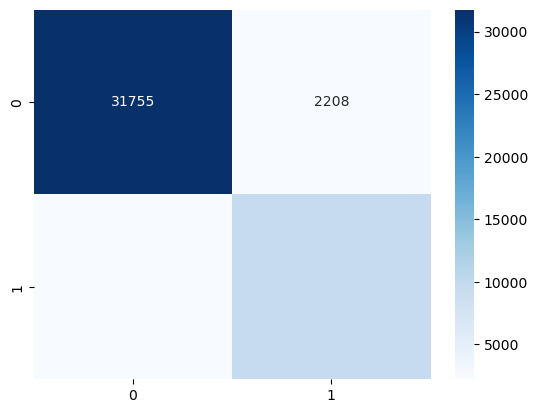

In [38]:
# Get metrics on the scored model
print('Acccuracy:', accuracy_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_df, y_true_col_name='"target"', y_pred_col_name='PREDICTION')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

We are happy with the metrics of the model above, so we can persist the scored trained dataset (if we want to use it later), and proceed to registering the model

## Model Deployment (Vectorized UDF)

In [39]:
# Create a stage for the model if it doesnt exist
session.sql("CREATE STAGE IF NOT EXISTS MODEL_ASSETS").collect()

[Row(status='Stage area MODEL_ASSETS successfully created.')]

In [40]:
# For this method, we convert the model to a local one, so we can stage it and deploy to Snowflake
lgbmodel_local = lgbmodel.to_lightgbm()

In [41]:
import joblib

# Let's save our model first
MODEL_FILE = 'model.joblib'
joblib.dump(lgbmodel_local, MODEL_FILE) # we are just pickling it locally first

# You can also save the pickled object into the stage we created earlier
session.file.put(MODEL_FILE, "@MODEL_ASSETS", overwrite=True)

[PutResult(source='model.joblib', target='model.joblib.gz', source_size=386351, target_size=169680, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

In [42]:
import cachetools
from snowflake.snowpark.functions import udf
# Cache the model load to optimize inference
@cachetools.cached(cache={})
def load_model(filename):
    import joblib
    import sys
    import os

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Register the UDF via decorator
@udf(name='batch_predict_cc_default', 
     session=session, 
     replace=True, 
     is_permanent=True, 
     stage_location='@MODEL_ASSETS',
     input_types=[F.FloatType()]*len(feature_cols),
     return_type=F.FloatType(),
     imports=['@MODEL_ASSETS/model.joblib.gz'],
     packages=['pandas','joblib','cachetools','lightgbm', 'numpy', 'scikit-learn'])
def batch_predict_cc_default(test_df: pd.DataFrame) -> pd.Series:
    # Need to name the columns because column names aren't passed in to this function
    test_df.columns = feature_cols
    model = load_model('model.joblib.gz')
    return model.predict(test_df) # This is using the XGBoost library's model.predict(), not Snowpark ML's

In [43]:
# This cell runs the model in a secure python sandbox in Snowflake
from snowflake.snowpark.functions import call_udf
scored_data = test_df.select('"customer_ID"', call_udf("batch_predict_cc_default", [F.col(c) for c in feature_cols]).alias('Prediction'))

In [44]:
# Persist the results to a table
scored_data.write.save_as_table(table_name='UDF_TEST_SCORED', mode='overwrite')

Now we have a UDF deployed in our Snowflake account called "batch_predict_cc_default" that we can use on incoming data.

## Productionize the Model

We have tested the feature engineering pipeline and the model performance, so we will now productionise the scoring of newly incoming data by leveraging Streams and Tasks. The Tasks will contain Stored Procedures which hold the logic for feature engineering and scoring models.

These can be create from Notebooks using Snowpark functions, but for this HOL we will switch back to Snowsight to demonstrate how it can be done from a SQL Worksheet.

Proceed to step 9 and stay in the Zamboni account